# Melanoma Classification

Kaggle Competition Page: www.kaggle.com/c/siim-isic-melanoma-classification/overview


## What is Melanoma?
Melanoma, the most severe type of skin cancer, develops in the cells (melanocytes) that produce melanin — the pigment that gives your skin its color. Melanoma can also form in your eyes and, rarely, inside your body, such as in your nose or throat.

The exact cause of all melanomas isn't clear, but exposure to ultraviolet (UV) radiation from sunlight or tanning lamps and beds increases your risk of developing melanoma.

The risk of melanoma seems to be increasing in people under 40, especially women. Knowing the warning signs of skin cancer can help ensure that cancerous changes are detected and treated before the cancer has spread. We can treat melanoma successfully if it is detected early.

<img src="https://github.com/SaschaMet/melanoma-classification/blob/master/images/melanoma.jpg?raw=1" alt="Drawing" style="width: 600px;"/>

## Symptoms & Diagnosis
Melanomas can develop anywhere on your body. They most often develop in areas with exposure to the sun, such as your back, legs, arms, and face.
Melanomas can also occur in areas that don't receive much sun exposure, such as the soles of your feet, palms of your hands, and fingernail beds. These hidden melanomas are more common in people with darker skin.

To help you identify characteristics of melanomas or other skin cancers, think of the letters ABCDE:
- A is for asymmetrical shape. Look for moles with irregular shapes, such as two very different-looking halves.
- B is for irregular border. Look for moles with rough, notched, or scalloped edges — characteristics of melanomas.
- C is for color changes. Look for growths that have many colors or an uneven distribution of color.
- D is for diameter. Look for new growth in a mole larger than 1/4 inch (about 6 millimeters).
- E is for evolving. Look for changes over time, such as a mole that grows in size or changes color or shape.


![ABCDE Melanoma](https://github.com/SaschaMet/melanoma-classification/blob/master/images/abcde-melanoma.jpg?raw=1)

Source: https://www.health.harvard.edu/cancer/melanoma-overview

The facts about Melanoma:
- Melanoma is the most severe form of skin cancer
- It makes up 2% of skin cancers but is responsible for 75% of skin cancer deaths
- Australia and New Zealand have the highest melanoma rates in the world
- 1 in 17 Australians will be diagnosed with melanoma before the age of 85
- More than 90% of melanoma can be successfully treated with surgery if detected early

Source: https://melanomapatients.org.au/about-melanoma/melanoma-facts/

<img src="https://github.com/SaschaMet/melanoma-classification/blob/master/images/melanoma-impact.jpg?raw=1" alt="Drawing" style="width: 600px;"/>

Source: https://impactmelanoma.org/wp-content/uploads/2018/11/Standard-Infographic_0.jpg

## Setup

In [2]:
import os
import json
import random
import warnings
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from pathlib import Path
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from datetime import datetime, date
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from keras.applications.vgg16 import VGG16
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, confusion_matrix

In [3]:
SEED = 1
EPOCHS = 40
BATCH_SIZE = 64
NUM_CLASSES = 2
VERBOSE_LEVEL = 2
SAVE_OUTPUT = True
IMG_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)

CWD = os.getcwd()
warnings.filterwarnings('ignore')

GOOGLE_COLAB = False
if CWD == "/content":
    %matplotlib inline
    GOOGLE_COLAB = True
    print ('Running in colab:', GOOGLE_COLAB)

Running in colab: True


In [4]:
# Tensorflow execution optimizations
# Source: https://www.tensorflow.org/guide/mixed_precision & https://www.tensorflow.org/xla
MIXED_PRECISION = True
XLA_ACCELERATE = True
GPUS = 0

GPUS = len(tf.config.experimental.list_physical_devices('GPU'))
if GPUS == 0:
    DEVICE = 'CPU'
else:
    DEVICE = 'GPU'
    if MIXED_PRECISION:
        from tensorflow.keras.mixed_precision import experimental as mixed_precision
        policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
        mixed_precision.set_policy(policy)
        print('Mixed precision enabled')
    if XLA_ACCELERATE:
        tf.config.optimizer.set_jit(True)
        print('Accelerated Linear Algebra enabled')

print("Tensorflow version " + tf.__version__)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale
Mixed precision enabled
Accelerated Linear Algebra enabled
Tensorflow version 2.4.0


In [5]:
BASE_PATH = '/kaggle/input/siim-isic-melanoma-classification'
PATH_TO_IMAGES = '/kaggle/input/siim-isic-melanoma-classification/jpeg' 
IMAGE_TYPE = ".jpg"

# check on which system we are
if os.path.exists(CWD + '/data'):
    BASE_PATH = os.path.join(CWD, 'data')
    PATH_TO_IMAGES = BASE_PATH
    IMAGE_TYPE = ".png"
    print("change BASE_PATH to ", BASE_PATH)

elif GOOGLE_COLAB:
    CWD = "/content/melanoma-classification"
    BASE_PATH = os.path.join(CWD, 'data')
    PATH_TO_IMAGES = BASE_PATH
    IMAGE_TYPE = ".png"
    print("change BASE_PATH to ", BASE_PATH)

change BASE_PATH to  /content/data


In [6]:
""" Helper function to seed everything for getting reproducible results
"""
def seed_all(seed):
    print("Set seed")
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_KERAS'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = str(seed)
    os.environ['TF_CUDNN_DETERMINISTIC'] = str(seed)
    tf.random.set_seed(seed)
    tf.experimental.numpy.random.seed(seed)
    
seed_all(SEED)

Set seed


## Loading the data

In [7]:
""" Helper function to validate the image paths

    Parameters:
        file_path (string): Path to the image 

    Returns:
        The file path if the file exists, otherwise false if the file does not exist

"""
def check_image(file_path):
    img_file = Path(file_path)
    if img_file.is_file():
        return file_path
    return False

In [8]:
""" Helper function to get the train dataset
"""
def get_train_data():
    # read the data from the train.csv file
    train = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    # add the image_path to the train set
    train['image_path'] = train['image_name'].apply(lambda x: PATH_TO_IMAGES + "/train/" + x + IMAGE_TYPE)
    # check if the we have an image 
    train['image_path'] = train.apply(lambda row : check_image(row['image_path']), axis = 1)
    # if we do not have an image we will not include the data
    train = train[train['image_path'] != False]
    print("valid rows in train", train.shape[0])
    return train

""" Helper function to get the test dataset
"""
def get_test_data():
    test = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))
    test['image_path'] = test['image_name'].apply(lambda x: PATH_TO_IMAGES + "/test/" + x + IMAGE_TYPE)
    test['image_path'] = test.apply(lambda row : check_image(row['image_path']), axis = 1)
    test = test[test['image_path'] != False]
    print("valid rows in test", test.shape[0])
    return test


In [9]:
train = get_train_data()
test = get_test_data()

valid rows in train 33126
valid rows in test 10982


In [10]:
train.dtypes

image_name                        object
patient_id                        object
sex                               object
age_approx                       float64
anatom_site_general_challenge     object
diagnosis                         object
benign_malignant                  object
target                             int64
image_path                        object
dtype: object

Train Dataset:
- image name: the filename for the specific image
- patient_id: unique patient id
- sex: gender of the patient
- age_approx: age of the patient
- anatom_site_general_challenge: location of the scan site
- diagnosis: information about the diagnosis
- benign_malignant: indicates if the scan result is malignant or benign
- target: 0 for benign and 1 for malignant
- image_path: path to the image

In [11]:
test.dtypes

image_name                        object
patient_id                        object
sex                               object
age_approx                       float64
anatom_site_general_challenge     object
image_path                        object
dtype: object

Test Dataset Consists Of:
- image name: the filename for the specific image
- patient_id: unique patient id
- sex: gender of the patient
- age_approx: age of the patient
- anatom_site_general_challenge: location of the scan site
- image_path: path to the image

## EDA

Pandas profiling is a Python module with which you can do an exploratory data analysis with just a few lines of code. Unfortunately, it does not work in every environment, so this has to be checked beforehand.

If you want to see this package's output, you can open the output.html file in your browser.

In [12]:
try:
    t = train[['image_name', 'patient_id', 'sex', 'age_approx', 'anatom_site_general_challenge', 'diagnosis', 'benign_malignant', 'target']]
    profile = ProfileReport(t, explorative=True)
    # output the report to html
    profile.to_file("output.html")
    # show the output inline
    profile
except:
    print("Pandas Profiling does not work in this environment")

Pandas Profiling does not work in this environment


### Check for missing values

In [13]:
""" Helper function check a dataframe for missing values

    Parameters:
        df (dataframe): The dataframe to check

    Returns:
        A dataframe with the number of missing and zero values for each column in percent

"""
def check_for_missing_and_null(df):
    null_df = pd.DataFrame({'columns': df.columns, 
                            'percent_null': df.isnull().sum() * 100 / len(df), 
                            'percent_zero': df.isin([0]).sum() * 100 / len(df),
                            'total_zero': df.isnull().sum() * 100 / len(df) + df.isin([0]).sum() * 100 / len(df),
                           })
    return null_df

check_for_missing_and_null(train)

columns  ...  total_zero
image_name                                        image_name  ...    0.000000
patient_id                                        patient_id  ...    0.000000
sex                                                      sex  ...    0.196220
age_approx                                        age_approx  ...    0.211314
anatom_site_general_challenge  anatom_site_general_challenge  ...    1.590895
diagnosis                                          diagnosis  ...    0.000000
benign_malignant                            benign_malignant  ...    0.000000
target                                                target  ...   98.237034
image_path                                        image_path  ...    0.000000

[9 rows x 4 columns]

There is a small portion of missing values for age and sex, as well as for the anatom_site_general_challenge column. 

The target column consists of 98 % zero values. This means we have a highly imbalanced dataset.

### Removing missing values

To do the EDA, I will remove the dataset's missing values because we will not lose much information. Later, when we prepare the dataset for training, I will add these missing values again.

In [14]:
train = train.dropna()

### Target distribution

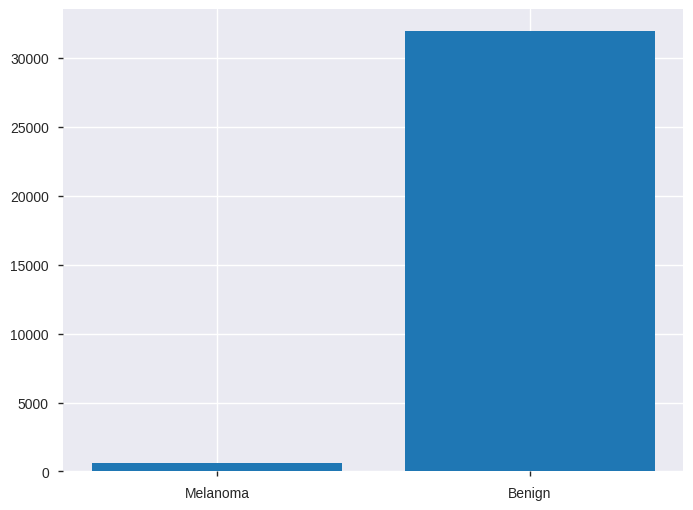

In [15]:
plt.figure(figsize = (8,6))
x = plt.bar(["Melanoma","Benign"],[len(train[train.target==1]), len(train[train.target==0])])

In [16]:
benign_cases = train[train.target == 0]
melanoma_cases = train[train.target == 1]

print("Benign Cases", len(benign_cases))
print("Melanoma Cases", len(melanoma_cases))
print(" ")
print("There are only", len(melanoma_cases), "malignant cases in the dataset. This is very important to know, because this has implications on how to perpare the dataset for training the machine learning model.")

Benign Cases 31956
Melanoma Cases 575
 
There are only 575 malignant cases in the dataset. This is very important to know, because this has implications on how to perpare the dataset for training the machine learning model.


### Gender distribution

There are 15743 female patients in the dataset and 16788 male patients.


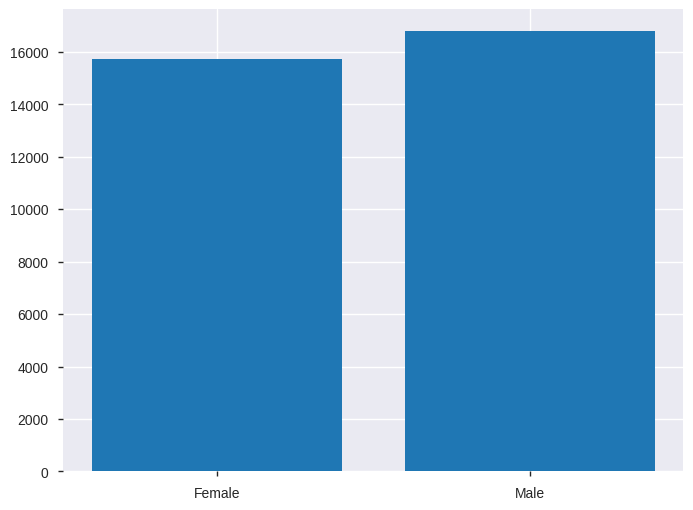

In [17]:
female = train[train.sex == "female"]
male = train[train.sex == "male"]
plt.figure(figsize = (8,6))
x = plt.bar(
    ["Female","Male"],
    [len(female), len(male)]
)
print('There are', len(female), 'female patients in the dataset and', len(male), 'male patients.')

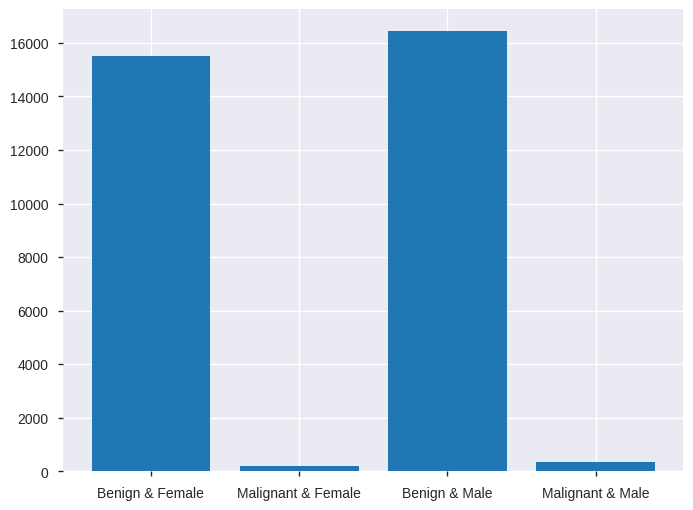

In [18]:
benign_cases_female = train[train.target==0][train.sex == "female"]
malignant_cases_female = train[train.target==1][train.sex == "female"]

benign_cases_male = train[train.target==0][train.sex == "male"]
malignant_cases_male = train[train.target==1][train.sex == "male"]

plt.figure(figsize = (8,6))
x = plt.bar(
    ["Benign & Female","Malignant & Female", "Benign & Male","Malignant & Male"],
    [len(benign_cases_female), len(malignant_cases_female), len(benign_cases_male), len(malignant_cases_male)]
)

In [19]:
grouped_df_by_sex = train.groupby(['target','sex'])['benign_malignant'].count().to_frame().reset_index()
grouped_df_by_sex

target     sex  benign_malignant
0       0  female             15526
1       0    male             16430
2       1  female               217
3       1    male               358

In [20]:
f_m = train[train.target == 1][train.sex == "female"]
m_m = train[train.target == 1][train.sex == "male"]

print("There are", len(m_m) ,"malignant male cases in the dataset compared to", len(f_m) ,"female cases.")

There are 358 malignant male cases in the dataset compared to 217 female cases.


### Age distribution

In [21]:
# create ten age bins, from 0 to 100
age_bins = np.arange(0, 100, 10)

""" Helper function to return the age bin for a specific age

    Parameters:
        age (int)

    Returns:
        age bin (int)
"""
def add_age_bin(age):
    for idx, val in enumerate(age_bins):
        if age < val:
            return idx

# add the age bins to the train df
train['age_bin'] = train.apply(lambda row : add_age_bin(row['age_approx']), axis = 1)

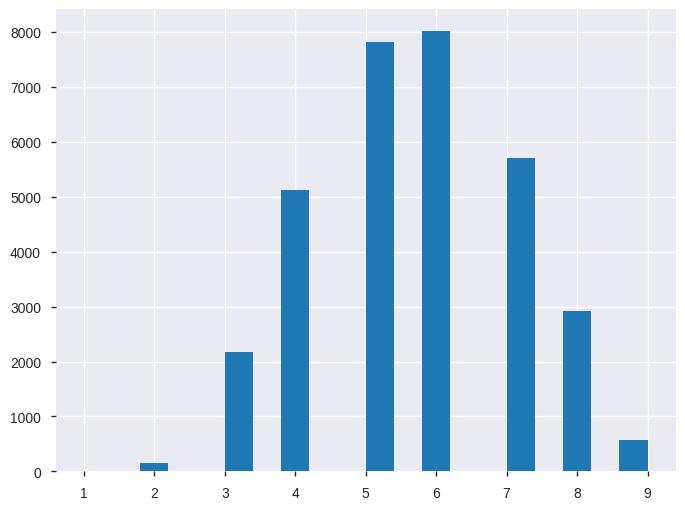

In [22]:
plt.figure(figsize=(8,6))
plt.hist( train.age_bin, bins = 20)
plt.show()

In [23]:
print("The mean age of a patient in the dataset is", round(np.mean(train.age_approx, 0)))

The mean age of a patient in the dataset is 49


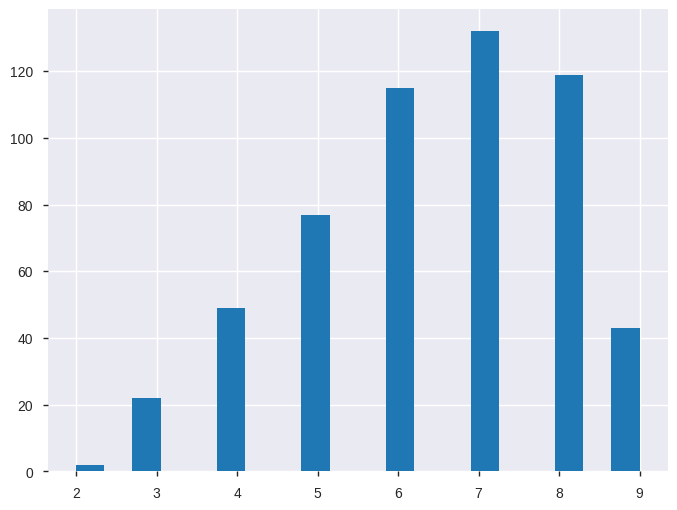

In [24]:
plt.figure(figsize=(8,6))
plt.hist( train[train.target==1].age_bin, bins = 20)
plt.show()

The age distributions follows a normal distribution. If we look only at the malignant cases however we can see, that the distribution seems to be wider. 

In [25]:
def get_ratio_by_age_bin(age_bin):
    total = train[train['age_bin'] == age_bin]
    malignant = train[train['age_bin'] == age_bin][train['target'] == 1]
    return round((len(malignant) / len(total)) * 100, 2)
    
for age_bin in [2,3,4,5,6,7,8]:
    print("Ratio malignant / total cases for age_bin", age_bin, "=" , get_ratio_by_age_bin(age_bin))


Ratio malignant / total cases for age_bin 2 = 1.34
Ratio malignant / total cases for age_bin 3 = 1.02
Ratio malignant / total cases for age_bin 4 = 0.96
Ratio malignant / total cases for age_bin 5 = 0.99
Ratio malignant / total cases for age_bin 6 = 1.44
Ratio malignant / total cases for age_bin 7 = 2.32
Ratio malignant / total cases for age_bin 8 = 4.07


There are indeed more malignant cases at the ends of the age distribution.

### Anatom Site General Challenge distribution

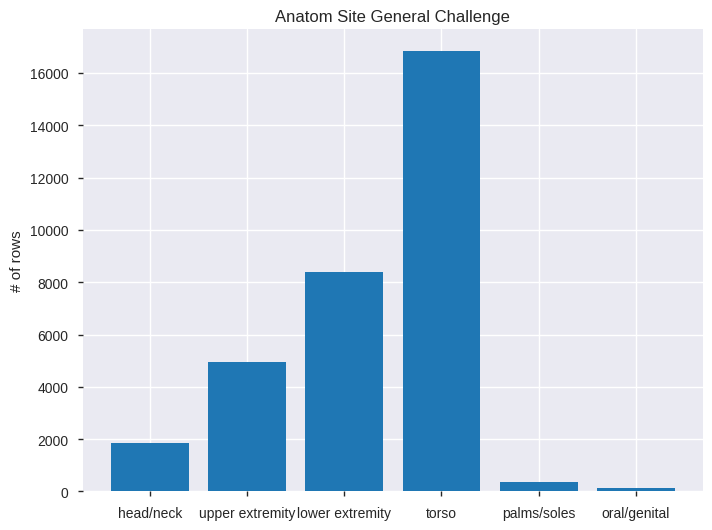

In [26]:
anatom_site = list(train.anatom_site_general_challenge.unique())
anatom_site = [x for x in anatom_site if str(x) != 'nan']

anatom_site_value_counts = []
for x in anatom_site:
    y = train[train['anatom_site_general_challenge'] == x]
    anatom_site_value_counts.append(len(y))

y_pos = np.arange(len(anatom_site))
plt.figure(figsize=(8,6))
plt.bar(y_pos, anatom_site_value_counts, align='center')
plt.xticks(y_pos, anatom_site)
plt.ylabel('# of rows')
plt.title('Anatom Site General Challenge')

plt.show()

Most often a lesion was found in the torso area, followed by the lower and upper extremity.

### Diagnosis distribution

In [27]:
diagnosis = list(train.diagnosis.unique())
diagnosis = [x for x in diagnosis if str(x) != 'unknown']

diagnosis_value_counts = []
for x in diagnosis:
    y = train[train['diagnosis'] == x]
    diagnosis_value_counts.append(len(y))

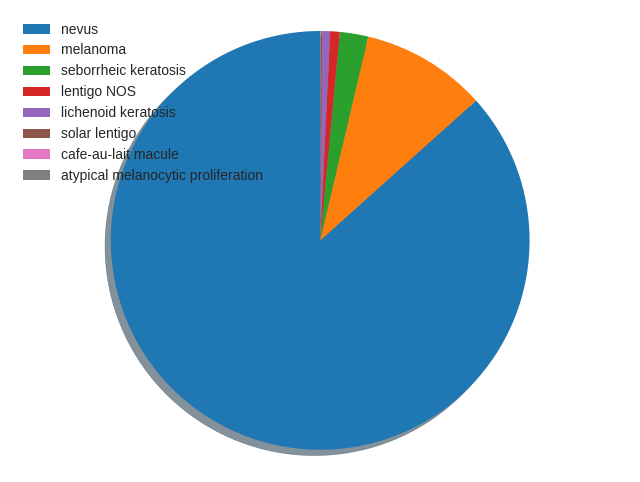

In [28]:
labels = diagnosis
sizes = diagnosis_value_counts
plt.figure(figsize=(8,6))
patches, texts = plt.pie(sizes, shadow=True, startangle=90)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.show()

The main finding in the dataset is "nevus". Nevus is a nonspecific medical term for a visible, circumscribed, chronic lesion of the skin (e.g. a "birthmark"). The second most common finding was melanoma.


Source: https://en.wikipedia.org/wiki/Nevus

## Images from the dataset

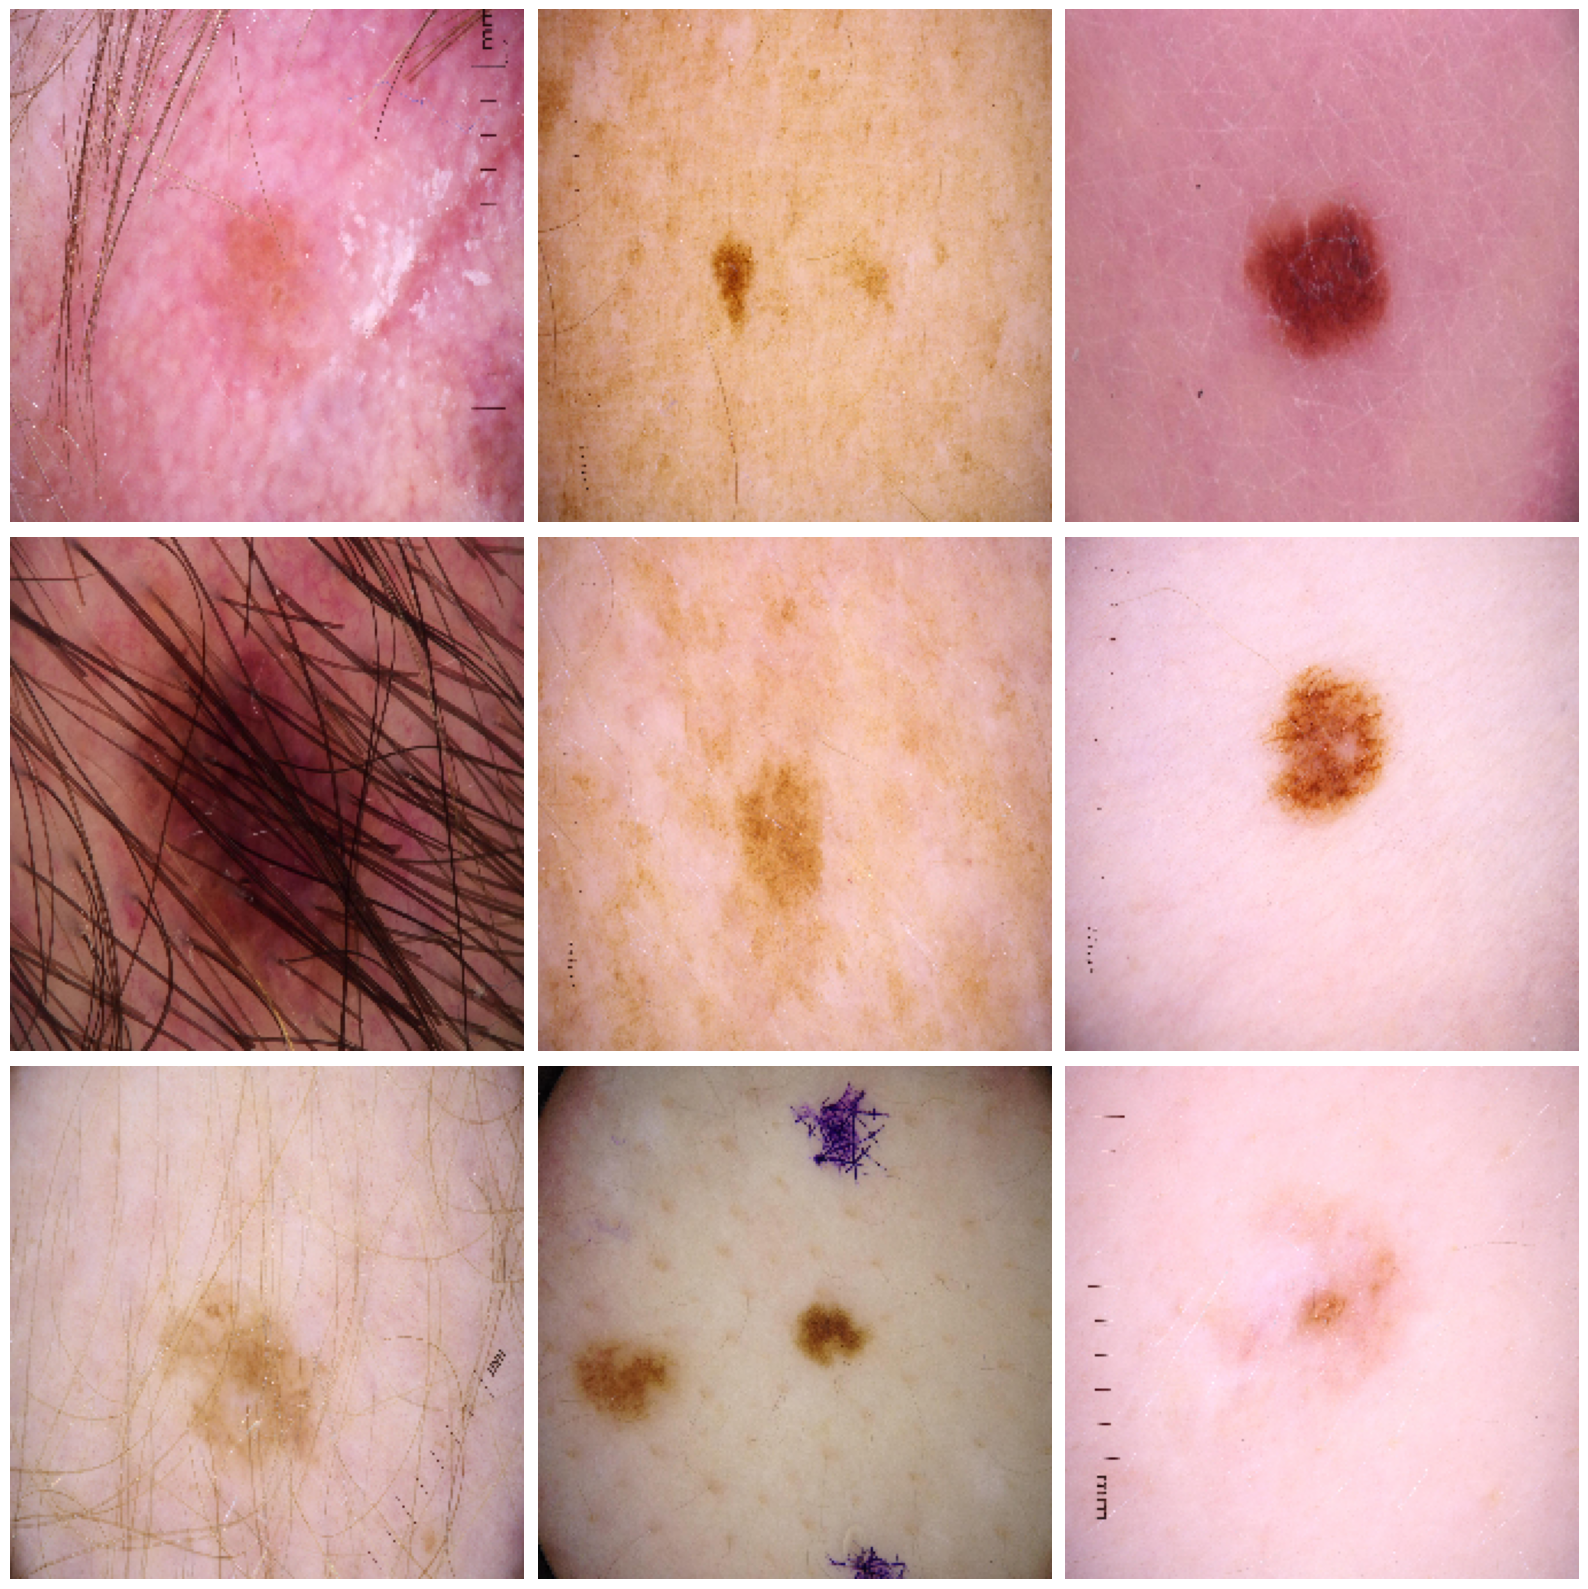

In [29]:
plt.figure(figsize=(16, 16))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img_path = train.iloc[i].image_path
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.tight_layout()   

## Histograms of pixel intensities

Histograms of pixel intensities show how frequently various color values occur in the image, i.e., frequency of pixels intensity values. In a black & white color space, pixel values range from 0 to 255, where 0 stands for black and 255 stands for white. Analysis of a histogram can help us understand the brightness, contrast, and intensity distribution of an image.

In [30]:
""" Helper function to plot the pixel intensitiy distribution for rgb images

    Parameters:
        image_path (str) The path to the image
        image_title (str) The title of the plot

    Returns:
        Null
"""
def print_image_dist(image_path, image_title):
    f = plt.figure(figsize=(16,8))
    f.add_subplot(1,2, 1)

    raw_image = plt.imread(image_path)
    plt.imshow(raw_image, cmap='gray')
    plt.colorbar()
    plt.title(image_title)
    print(f"Image dimensions:  {raw_image.shape[0],raw_image.shape[1]}")
    print(f"Maximum pixel value : {raw_image.max():.1f} ; Minimum pixel value:{raw_image.min():.1f}")
    print(f"Mean value of the pixels : {raw_image.mean():.1f} ; Standard deviation : {raw_image.std():.1f}")

    f.add_subplot(1,2, 2)

    _ = plt.hist(raw_image[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
    _ = plt.hist(raw_image[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
    _ = plt.hist(raw_image[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
    _ = plt.xlabel('Intensity Value')
    _ = plt.ylabel('Count')
    _ = plt.legend(['Red_Channel', 'Green_Channel', 'Blue_Channel'])
    plt.show()

In [31]:
benign_img = train[train['benign_malignant'] == "benign"].iloc[0]
benign_img

image_name                                               ISIC_2637011
patient_id                                                 IP_7279968
sex                                                              male
age_approx                                                         45
anatom_site_general_challenge                               head/neck
diagnosis                                                     unknown
benign_malignant                                               benign
target                                                              0
image_path                       /content/data/train/ISIC_2637011.png
age_bin                                                             5
Name: 0, dtype: object

Image dimensions:  (224, 224)
Maximum pixel value : 1.0 ; Minimum pixel value:0.0
Mean value of the pixels : 0.7 ; Standard deviation : 0.2


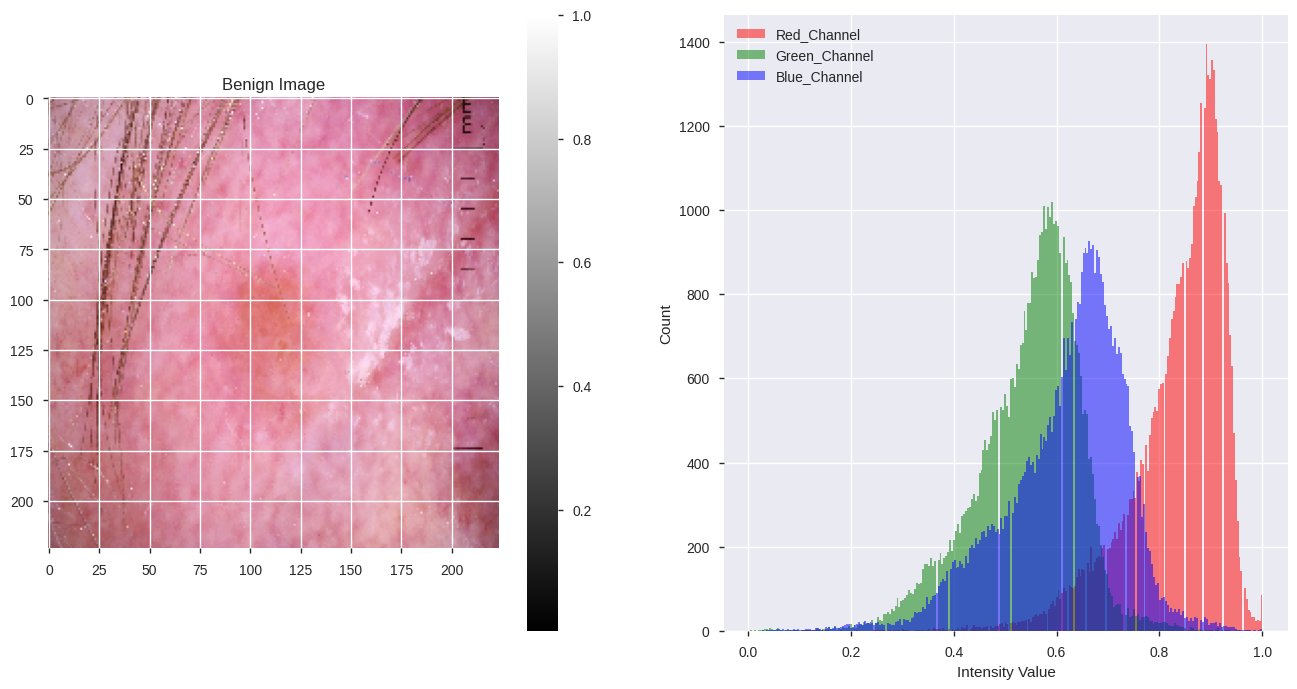

In [32]:
print_image_dist(benign_img['image_path'], 'Benign Image')

This image shows a benign finding located in the head/neck area. The mean value of the pixels is 0.7. The standard deviation is 0.2. The distribution of the RGB-Channels follows a normal distribution. The Red Channel is overrepresented in this image.

In [33]:
malignant_img = train[train['benign_malignant'] == "malignant"].iloc[0]
malignant_img

image_name                                               ISIC_0149568
patient_id                                                 IP_0962375
sex                                                            female
age_approx                                                         55
anatom_site_general_challenge                         upper extremity
diagnosis                                                    melanoma
benign_malignant                                            malignant
target                                                              1
image_path                       /content/data/train/ISIC_0149568.png
age_bin                                                             6
Name: 91, dtype: object

Image dimensions:  (224, 224)
Maximum pixel value : 1.0 ; Minimum pixel value:0.0
Mean value of the pixels : 0.7 ; Standard deviation : 0.1


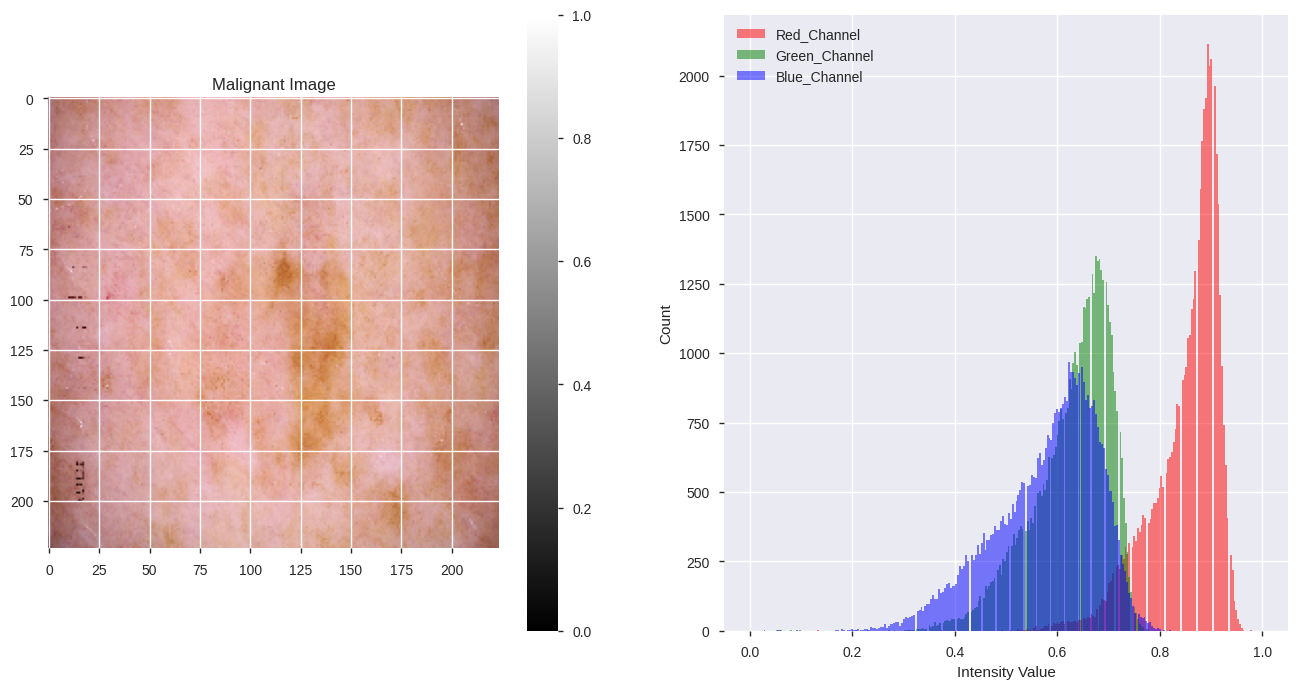

In [34]:
print_image_dist(malignant_img['image_path'], 'Malignant Image')

This image shows a malignant finding located in the upper extremity area. The mean value of the pixels is 0.7. The standard deviation is 0.1. The distribution, as well as the over representative Red-Channel, is similar to the benign image.

Based on these two images, we can already see how hard it is to identify a melanoma correctly.

## Data preparation

Because we removed some values from the dataset for the EDA, we load the train and test set again.

In [35]:
train = get_train_data()
test = get_test_data()

valid rows in train 33126
valid rows in test 10982


In [36]:
# reduce amount of data when running on a cpu
if DEVICE == 'CPU':
    print("reduce the amount of data because of cpu a runtime")
    # take 30% of the available data
    train = train.sample(int(train.shape[0] * 0.3))
    EPOCHS = 5
    SAVE_OUTPUT = False

In [37]:
# getting dummy variables for gender
sex_dummies = pd.get_dummies(train['sex'], prefix='sex', dtype="int")
train = pd.concat([train, sex_dummies], axis=1)

sex_dummies = pd.get_dummies(test['sex'], prefix='sex', dtype="int")
test = pd.concat([test, sex_dummies], axis=1)

# getting dummy variables for anatom_site_general_challenge
anatom_dummies = pd.get_dummies(train['anatom_site_general_challenge'], prefix='anatom', dtype="int")
train = pd.concat([train, anatom_dummies], axis=1)

anatom_dummies = pd.get_dummies(test['anatom_site_general_challenge'], prefix='anatom', dtype="int")
test = pd.concat([test, anatom_dummies], axis=1)

# getting dummy variables for target column
target_dummies = pd.get_dummies(train['target'], prefix='target', dtype="int")
train = pd.concat([train, target_dummies], axis=1)

# dropping not useful columns
train.drop(['sex','diagnosis','benign_malignant','anatom_site_general_challenge'], axis=1, inplace=True)
test.drop(['sex','anatom_site_general_challenge'], axis=1, inplace=True)

# replace missing age values wiht the mean age
train['age_approx'] = train['age_approx'].fillna(int(np.mean(train['age_approx'])))
test['age_approx'] = test['age_approx'].fillna(int(np.mean(test['age_approx'])))

# convert age to int
train['age_approx'] = train['age_approx'].astype('int')
test['age_approx'] = test['age_approx'].astype('int')

print("rows in train", train.shape[0])
print("rows in test", test.shape[0])

rows in train 33126
rows in test 10982


In [38]:
train.dtypes

image_name                object
patient_id                object
age_approx                 int64
target                     int64
image_path                object
sex_female                 int64
sex_male                   int64
anatom_head/neck           int64
anatom_lower extremity     int64
anatom_oral/genital        int64
anatom_palms/soles         int64
anatom_torso               int64
anatom_upper extremity     int64
target_0                   int64
target_1                   int64
dtype: object

In [39]:
test.dtypes

image_name                object
patient_id                object
age_approx                 int64
image_path                object
sex_female                 int64
sex_male                   int64
anatom_head/neck           int64
anatom_lower extremity     int64
anatom_oral/genital        int64
anatom_palms/soles         int64
anatom_torso               int64
anatom_upper extremity     int64
dtype: object

### Balance the dataset

Because we have a highly imbalanced dataset we need to balance it.

In [40]:
# 1 means 50 / 50 => equal amount of positive and negative cases in Training
# 4 = 20%; 8 = ~11%; 12 = ~8%
balance = 1
p_inds = train[train.target == 1].index.tolist()
np_inds = train[train.target == 0].index.tolist()

np_sample = random.sample(np_inds, balance * len(p_inds))
train = train.loc[p_inds + np_sample]
print("Samples in train", train['target'].sum()/len(train))
print("Remaining rows in train set", len(train))

Samples in train 0.5
Remaining rows in train set 1168


### Patient Overlap

Important to note is that there are patients with multiple images taken in both train and test datasets.
We, therefore, need to check that the same patient images do not appear in the training and test set.


In [41]:
print("Max number of images from one patient in the train set:", np.max(train.patient_id.value_counts()))
print("Max number of images from one patient in the test set:", np.max(test.patient_id.value_counts()))

Max number of images from one patient in the train set: 8
Max number of images from one patient in the test set: 240


In [42]:
# get the unique patient ids from the test and training set
ids_train = set(train.patient_id.values)
ids_test = set(test.patient_id.values)

print("There are", len(ids_train), "unique patients in the training set")
print("There are", len(ids_test), "unique patients in the test set")

# Identify patient overlap by looking at the intersection between the sets
patient_overlap = list(ids_train.intersection(ids_test))
n_overlap = len(patient_overlap)
print("There are", n_overlap, "patients in both the training and test sets")

There are 794 unique patients in the training set
There are 690 unique patients in the test set
There are 0 patients in both the training and test sets


In [43]:
""" Helper function to create a train and a validation dataset

    Parameters:
    df (dataframe): The dataframe to split
    test_size (int): Size of the validation set
    classToPredict: The target column

    Returns:
    train_data (dataframe)
    val_data (dataframe)
"""
def create_splits(df, test_size, classToPredict):
    train_data, val_data = train_test_split(df,  test_size = test_size, random_state = SEED, stratify = df[classToPredict])
    return train_data, val_data

In [44]:
""" Helper function to plot the history of a tensorflow model

    Parameters:
        history (history object): The history from a tf model
        timestamp (string): The timestamp of the function execution

    Returns:
        Null
"""
def save_history(history, timestamp):
    f = plt.figure()
    f.set_figwidth(15)

    f.add_subplot(1, 2, 1)
    plt.plot(history['val_loss'], label='val loss')
    plt.plot(history['loss'], label='train loss')
    plt.legend()
    plt.title("Modell Loss")

    f.add_subplot(1, 2, 2)
    plt.plot(history['val_accuracy'], label='val accuracy')
    plt.plot(history['accuracy'], label='train accuracy')
    plt.legend()
    plt.title("Modell Accuracy")

    if SAVE_OUTPUT:
        plt.savefig("./" + timestamp + "-history.png")
        with open("./" + timestamp + "-history.json", 'w') as f:
            json.dump(history, f)

In [45]:
""" Helper function to plot the auc curve

    Parameters:
        t_y (array): True binary labels
        p_y (array): Target scores

    Returns:
        Null
"""
def plot_auc(t_y, p_y):
    fpr, tpr, thresholds = roc_curve(t_y, p_y, pos_label=1)
    fig, c_ax = plt.subplots(1,1, figsize = (8, 8))
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Target', auc(fpr, tpr)))
    c_ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')

## Data augmentation

In [46]:
""" Factory function to create a training image data generator

Parameters:
    df (dataframe): Training dataframe 

Returns:
    Image Data Generator function
"""
def get_training_gen(df):
    ## prepare images for training
    train_idg = ImageDataGenerator(
        rescale = 1 / 255.0,
        horizontal_flip = True, 
        vertical_flip = True, 
        height_shift_range = 0.15, 
        width_shift_range = 0.15,
        shear_range=0.15,
        rotation_range = 90, 
        zoom_range = 0.20,
        fill_mode='nearest'
    )

    train_gen = train_idg.flow_from_dataframe(
        seed=SEED,
        dataframe=df,
        directory=None,
        x_col='image_path',
        y_col=['target_0','target_1'],
        class_mode='raw',
        shuffle=True,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        validate_filenames = False
    )

    return train_gen

In [47]:
""" Factory function to create a validation image data generator

Parameters:
    df (dataframe): Validation dataframe 

Returns:
    Image Data Generator function
"""
def get_validation_gen(df):
    ## prepare images for validation
    val_idg = ImageDataGenerator(rescale=1. / 255.0)
    val_gen = val_idg.flow_from_dataframe(
        seed=SEED,
        dataframe=df,
        directory=None,
        x_col='image_path',
        y_col=['target_0','target_1'],
        class_mode='raw',
        shuffle=False,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        validate_filenames = False
    )

    return val_gen

### Images returned from the ImageDataGenerator

Found 1168 non-validated image filenames.


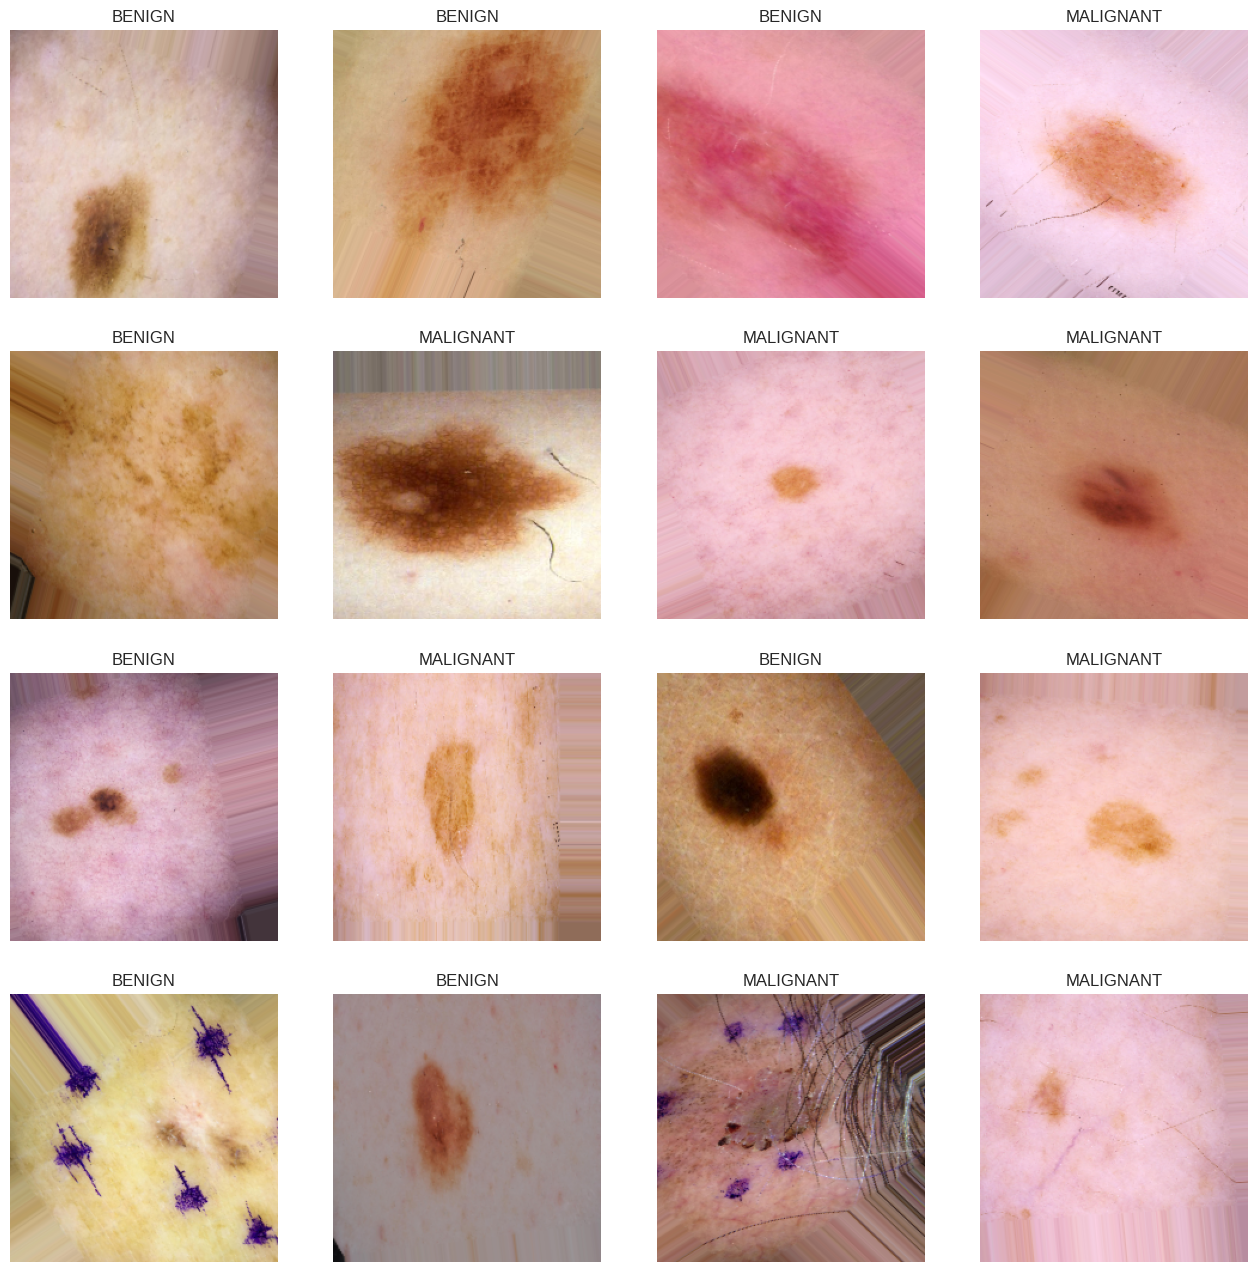

In [48]:
train_gen = get_training_gen(train)
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x, cmap = 'bone')
    if c_y[0] == 1: 
        c_ax.set_title('MALIGNANT')
    else:
        c_ax.set_title('BENIGN')
    c_ax.axis('off')

The Image Data Generator function returns these transformed images.

The Keras ImageDataGenerator class works by:
- Accepting a batch of images used for training.
- Taking this batch and applying a series of random transformations to each image in the batch (including random rotation, resizing, shearing, etc.).
- Replacing and returning the original batch with the new, randomly transformed batch.

Source: https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/

## Transfer Learning

Conventional machine learning and deep learning algorithms, so far, have been traditionally designed to work in isolation. These algorithms are trained to solve specific tasks. The models have to be rebuilt from scratch once the feature-space distribution changes. Transfer learning is the idea of overcoming the isolated learning paradigm and utilizing knowledge acquired for one task to solve related ones. 


![Transfer Learning](https://github.com/SaschaMet/melanoma-classification/blob/master/images/transfer-learning.png?raw=1)
 

Traditional learning is isolated and occurs purely based on specific tasks, datasets, and training separate isolated models on them. No knowledge is retained, which can be transferred from one model to another. In transfer learning, you can leverage knowledge (features, weights, etc.) from previously trained models for training newer models and even tackle problems like having less data for the more recent task.

**Fine Tuning Off-the-shelf Pre-trained Models**

This is a more involved technique, where we do not just replace the final layer (for classification/regression), but we also selectively retrain some of the previous layers. 


![Transfer Learning](https://miro.medium.com/max/700/1*BBZGHtI_vhDBeqsIbgMj1w.png)
 



Source: https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a

In [49]:
""" Helper function which returns a VGG16 model
"""
def load_pretrained_model():
    base_model = VGG16(
        input_shape=INPUT_SHAPE,
        include_top=False,
        weights='imagenet'
    )
    
    # freeze the first 15 layers of the base model. All other layers are trainable.
    for layer in base_model.layers[0:15]:
        layer.trainable = False

    for idx, layer in enumerate(base_model.layers):
        print("layer", idx + 1, ":", layer.name, "is trainable:", layer.trainable)

    return base_model


""" Helper function which returns a tensorflow model
"""
def create_model():
    print("create model")

    # Create a new sequentail model and add the pretrained model
    model = Sequential()

    # Add the pretrained model
    model.add(load_pretrained_model())  

    # Add a flatten layer to prepare the ouput of the cnn layer for the next layers
    model.add(layers.Flatten())

    # Add a dense (aka. fully-connected) layer. 
    # Add a dropout-layer which may prevent overfitting and improve generalization ability to unseen data.
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(32, activation='relu'))

    # Use the Sigmoid activation function for binary predictions, softmax for n-classes
    # We use the softmax function, because we have two classes (target_0 & target_1)
    model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

    return model

In [50]:
model = create_model()
model.summary()

create model
58892288/58889256 [==============================] - 0s 0us/step
layer 1 : input_1 is trainable: False
layer 2 : block1_conv1 is trainable: False
layer 3 : block1_conv2 is trainable: False
layer 4 : block1_pool is trainable: False
layer 5 : block2_conv1 is trainable: False
layer 6 : block2_conv2 is trainable: False
layer 7 : block2_pool is trainable: False
layer 8 : block3_conv1 is trainable: False
layer 9 : block3_conv2 is trainable: False
layer 10 : block3_conv3 is trainable: False
layer 11 : block3_pool is trainable: False
layer 12 : block4_conv1 is trainable: False
layer 13 : block4_conv2 is trainable: False
layer 14 : block4_conv3 is trainable: False
layer 15 : block4_pool is trainable: False
layer 16 : block5_conv1 is trainable: True
layer 17 : block5_conv2 is trainable: True
layer 18 : block5_conv3 is trainable: True
layer 19 : block5_pool is trainable: True
Model: "sequential"
_________________________________________________________________
Layer (type)           

In [51]:
# get the current timestamp. This timestamp is used to save the model data with a unique name
now = datetime.now()
today = date.today()
current_time = now.strftime("%H:%M:%S")
timestamp = str(today) + "_" + str(current_time)

In [52]:
callback_list = []

# if the model does not improve for 10 epochs, stop the training
# we choose val_loss as a metric for ealry stopping, because the lower the loss, the better the model
stop_early = EarlyStopping(monitor='val_loss', mode='auto', patience=10)
callback_list.append(stop_early)

# if the output of the model should be saved, create a checkpoint callback function
if SAVE_OUTPUT:
    # set the weight path for saving the model
    weight_path = "./" + timestamp + "-model.hdf5"
    # create the model checkpoint callback to save the model wheights to a file
    checkpoint = ModelCheckpoint(
        weight_path,
        save_weights_only=True,
        verbose=VERBOSE_LEVEL,
        save_best_only=True,
        monitor='val_accuracy', # we want to save the model with the best accuracy
        overwrite=True,
        mode='auto',
    )
    # append the checkpoint callback to the callback list
    callback_list.append(checkpoint)

## Model training

In [53]:
# create a training and validation dataset from the train df
train_df, val_df = create_splits(train, 0.2, 'target')

print("rows in train_df", train_df.shape[0])
print("rows in val_df", val_df.shape[0])

# because we do not need the target column anymore we can drop it
train_df.drop(['target'], axis=1, inplace=True)
val_df.drop(['target'], axis=1, inplace=True)

# call the generator functions
train_gen = get_training_gen(train_df)
val_gen = get_validation_gen(val_df)
valX, valY = val_gen.next()

rows in train_df 934
rows in val_df 234
Found 934 non-validated image filenames.
Found 234 non-validated image filenames.


In [54]:
LEARNING_RATE = 1e-4
OPTIMIZER = Adam(lr=LEARNING_RATE)
LOSS = 'binary_crossentropy'
METRICS = [
    'accuracy', 
    'AUC'
] 

model.compile(
    loss=LOSS,
    metrics=METRICS,
    optimizer=OPTIMIZER,
)

# when on a cpu, do not save the model data
if DEVICE == 'CPU':
    print("fit model on cpu")
    history = model.fit(
        train_gen, 
        epochs=EPOCHS, 
        verbose=VERBOSE_LEVEL,
        validation_data=(valX, valY)
    )
else:
    print("fit model on gpu")
    history = model.fit(
        train_gen, 
        epochs=EPOCHS, 
        verbose=VERBOSE_LEVEL,
        callbacks=callback_list, 
        validation_data=(valX, valY),
    )

  opt = tf.keras.mixed_precision.experimental.LossScaleOptimizer(opt)

fit model on gpu
Epoch 1/40
15/15 - 29s - loss: 0.6926 - accuracy: 0.5439 - auc: 0.5690 - val_loss: 0.6760 - val_accuracy: 0.5000 - val_auc: 0.5933

Epoch 00001: val_loss improved from inf to 0.67603, saving model to ./2021-01-08_11:54:16-model.hdf5
Epoch 2/40
15/15 - 14s - loss: 0.6479 - accuracy: 0.6317 - auc: 0.6752 - val_loss: 0.5916 - val_accuracy: 0.7344 - val_auc: 0.7870

Epoch 00002: val_loss improved from 0.67603 to 0.59155, saving model to ./2021-01-08_11:54:16-model.hdf5
Epoch 3/40
15/15 - 11s - loss: 0.6185 - accuracy: 0.6734 - auc: 0.7350 - val_loss: 0.5593 - val_accuracy: 0.7969 - val_auc: 0.8127

Epoch 00003: val_loss improved from 0.59155 to 0.55933, saving model to ./2021-01-08_11:54:16-model.hdf5
Epoch 4/40
15/15 - 11s - loss: 0.5931 - accuracy: 0.6884 - auc: 0.7562 - val_loss: 0.5465 - val_accuracy: 0.7188 - val_auc: 0.8158

Epoch 00004: val_loss improved from 0.55933 to 0.54651, saving model to .

## Model Evaluation

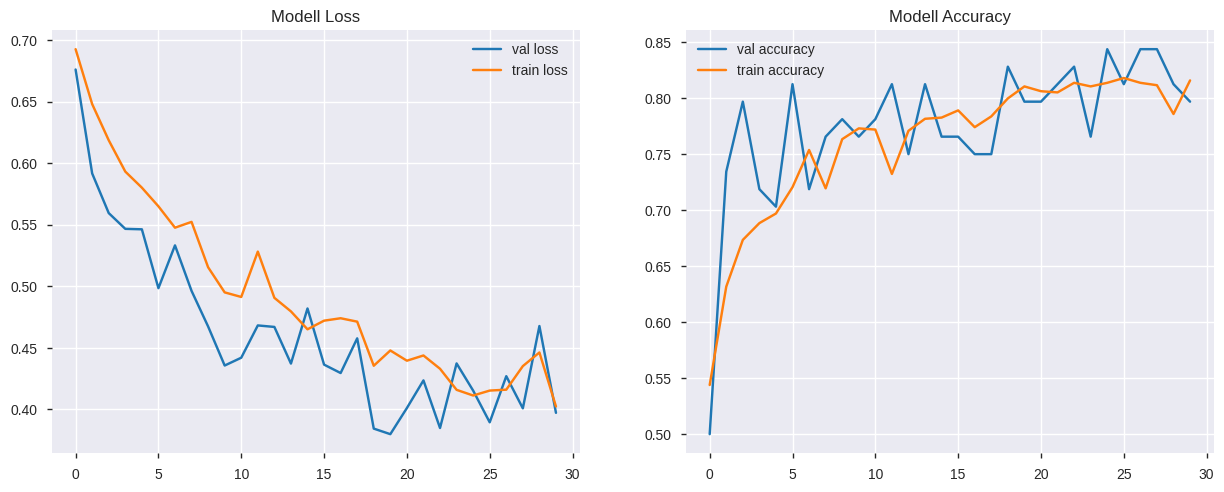

In [55]:
# plot model history
save_history(history.history, timestamp)

From the accuracy plot, we can see that the model stops learning after epoch 22. We can also see that the model has not yet over-learned the training dataset. We can see that the model has comparable performance on both train and validation datasets from the loss plot. The model achieved the lowest loss at the 19th epoch.

However, the plots suggest that our model has difficulty generalizing, as the validation curves vary widely in some cases.

100%|██████████| 234/234 [00:10<00:00, 23.02it/s]


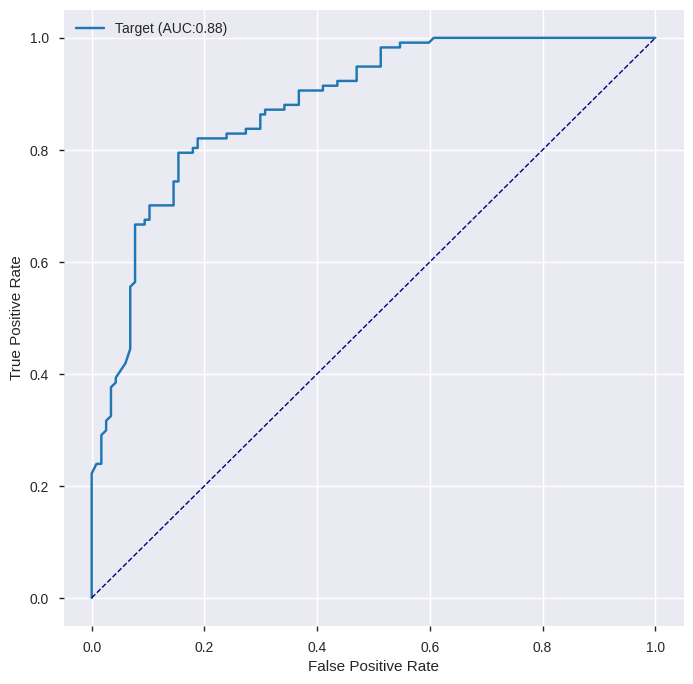

In [56]:
# plot the auc
y_t = [] # true labels
y_p = [] # predictions

# iterate over the validation df and make a prediction for each image
for i in tqdm(range(val_df.shape[0])):
    y_true = val_df.iloc[i].target_1
    image_path = val_df.iloc[i].image_path

    img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img = keras.preprocessing.image.img_to_array(img)
    img = img / 255
    img_array = tf.expand_dims(img, 0)
    y_pred = model.predict(img_array)
    y_pred = tf.nn.softmax(y_pred)[0].numpy()[1]

    y_t.append(y_true)
    y_p.append(y_pred)

plot_auc(y_t, y_p)

AUC - ROC curve is a performance measurement for the classification problem at various threshold settings. ROC is a probability curve, and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0s as 0s and 1s as 1s. By analogy, the Higher the AUC, the better the model is at distinguishing between patients with the disease and no disease. The ROC curve is plotted with TPR against the FPR, where TPR is on the y-axis and FPR is on the x-axis.

Source: https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5

### F1 Score Calculation

The F1 score is the harmonic mean of precision and recall. In a statistical analysis of binary classification, the F-score is a measure of a test's accuracy. It is calculated from the precision and recall of the test, where the precision is the number of correctly identified positive results divided by the number of all positive outcomes, including those not identified correctly. The recall is the number of correctly identified positive results divided by the number of all samples that should have been identified as positive.

The highest possible value of an F-score is 1, indicating perfect precision and recall, and the lowest potential value is 0 if either the precision or the recall is zero.

Source: https://en.wikipedia.org/wiki/F-score

In [57]:
""" Helper function to calculate the F1 Score

    Parameters:
        prec (int): precision
        recall (int): recall

    Returns:
        f1 score (int)
"""
def calc_f1(prec, recall):
    return 2*(prec*recall)/(prec+recall) if recall and prec else 0

# calculate the precision, recall and the thresholds
precision, recall, thresholds = precision_recall_curve(y_t, y_p)

# calculate the f1 score
f1score = [calc_f1(precision[i],recall[i]) for i in range(len(thresholds))]

# get the index from the highest f1 score
idx = np.argmax(f1score)

# get the precision, recall, threshold and the f1score
precision = round(precision[idx], 4)
recall = round(recall[idx], 4)
threshold = round(thresholds[idx], 4)
f1score = round(f1score[idx], 4)

print('Precision:', precision)
print('Recall:', recall)
print('Threshold:', threshold)
print('F1 Score:', f1score)

Precision: 0.8136
Recall: 0.8205
Threshold: 0.561
F1 Score: 0.817


In [58]:
""" Helper function turn the model predictions into a binary (0,1) format

    Parameters:
        pred (float): Model prediction

    Returns:
        binary prediction (int)
"""
def pred_to_binary(pred):
    if pred < threshold:
        return 0
    else:
        return 1

y_pred_binary = [pred_to_binary(x) for x in y_p]

In [59]:
# create a confusion matrix
cm =  confusion_matrix(y_t, y_pred_binary)
cm

array([[95, 22],
       [21, 96]])

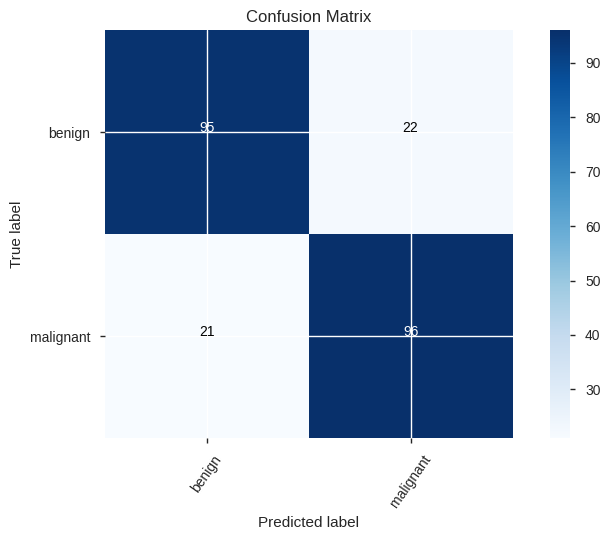

In [60]:
""" Helper function to plot a confusion matrix

    Parameters:
        cm (confusion matrix)

    Returns:
        Null
"""
def plot_confusion_matrix(cm, labels):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=55)
    plt.yticks(tick_marks, labels)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label)

The model predicted 191 images correclty, but failed on 43.

## Inference

Chance of beeing malignant: 0.27 %


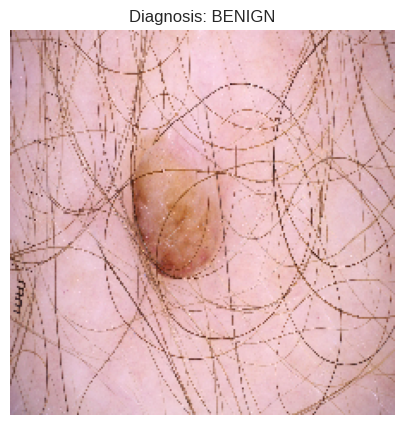

In [61]:
# Show a prediction for a random image
image_path = test.iloc[0].image_path
img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
img = keras.preprocessing.image.img_to_array(img)
img = img / 255
img_array = tf.expand_dims(img, 0)

prediction = np.max(tf.nn.softmax(model.predict(img_array)[0])[1])
print("Chance of beeing malignant: {:.2f} %".format(prediction))

finding = "Diagnosis: BENIGN"
if prediction > threshold:
    finding = "Diagnosis: MALIGNANT"

x = plt.figure(figsize=(5,5))
x = plt.imshow(img)
x = plt.title(finding)
x = plt.axis("off")

## Discussion

We achieved an F1-Score of 0.817. Based on a study from Han SS, Moon IJ, Lim W, et al. "Keratinocytic Skin Cancer Detection on the Face Using Region-Based Convolutional Neural Network" the F1-score of a professional dermatologist is 0.835. Compared to this result, our neural network performed slightly worse. It should be noted, however, that only facial skin cancer was considered in this study. The F1-Score of professional dermatologists on a more realistic dataset like this one could therefore differ.


Source: https://pubmed.ncbi.nlm.nih.gov/31799995/

<img src="https://github.com/SaschaMet/melanoma-classification/blob/master/images/clinical_relevance.png?raw=1" alt="Clinical Relevance" style="width: 600px;"/>

Source: https://www.udacity.com/course/ai-for-healthcare-nanodegree--nd320

Precision and Recall are of particular interest to the clinical applicability of the model. A model with high precision has increased confidence in a positive result. It is, therefore, better suited in confirming a diagnosis. A model with high Recall, on the other hand, is most confident when the test is negative. Such a model is better used for prioritization tasks (e.g., which lesions should be looked at first).

The precision of this model is 0.8136. The recall is 0.8205. This neural network should be better suited for prioritization tasks than for confirming a diagnosis. But, because we achieved an F1-Score comparable to professional dermatologists, plus precision and recall are almost the same, the model could also be useful in, e.g., confirming a dermatologist's diagnosis.

### Cut-Off Thresholds

The output of our CNN's last layer will output a probability that an image belongs to a given class (target_0 or target_1). Changing the threshold for this classification will transform the true positive, false positive, false negative, and true negative rates. This will, in turn, change the precision and recall of our model. We could, for example, change the threshold so that our precision increases. This, however, has the result that our recall changes and probably even decreases. One metric is optimized at the expense of another. Because of this, we used the F1-Score as a final metric because the F1-Score combines both precision and recall. (It is the harmonic mean of precision and recall.)

### Kaggle Leaderboard

When predicting the images from the provided test set, the model achieves a private score of 0.8041 and a public score of 0.8247. This results in a place on the leaderboard at around 2.700.

The best model on the private leaderboard of the Kaggle competition achieved a score of 0.9490.

All submissions are evaluated on the area under the ROC curve between the predicted probability and the observed target.

## How to further improve the model

Based on the placement on the leaderboard, you can already see that there is still a lot of potential for optimization. The following possibilities could be addressed, for example:

- Try different pre-trained models: https://keras.io/api/applications
- Hyperparameter tuning: https://blog.tensorflow.org/2020/01/hyperparameter-tuning-with-keras-tuner.html
- Get more training data: https://www.kaggle.com/wanderdust/skin-lesion-analysis-toward-melanoma-detection
- Experiment with different loss functions: https://www.tensorflow.org/addons/api_docs/python/tfa/losses/SigmoidFocalCrossEntropy
- Improve the data augmentation, e.g. by removing body hair: https://www.kaggle.com/vatsalparsaniya/melanoma-hair-remove

However, even with these options, it will be challenging to get a top ranking on the leaderboard. For example, the winning team consists of three Kaggle Grandmasters, all of whom work at NVIDIA. In an interview, they also mentioned that one of their most significant advantages was the abundant resources (e.g., GPUs) they received from NVIDIA.

Source: https://www.youtube.com/watch?v=L1QKTPb6V_I

In [62]:
if SAVE_OUTPUT:
    # save the model to a json file
    model_json = model.to_json()
    with open("./" + timestamp + "-model.json", "w") as json_file:
        json_file.write(model_json)

    # create the submission.csv file
    data=[]
    for i in tqdm(range(test.shape[0])):
        image_path = test.iloc[i].image_path
        image_name = test.iloc[i].image_name
        img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
        img = keras.preprocessing.image.img_to_array(img)
        img = img / 255
        img_array = tf.expand_dims(img, 0)
        y_pred = model.predict(img_array)
        y_pred = tf.nn.softmax(y_pred)[0].numpy()[1]
        data.append([image_name, y_pred])

    sub_df = pd.DataFrame(data, columns = ['image_name', 'target']) 
    sub_df.to_csv("./submission.csv", index=False)

    sub_df.head()

100%|██████████| 10982/10982 [07:31<00:00, 24.35it/s]
